In [ ]:
import copy
import dataclasses
import os
import pathlib
import subprocess
import sys
import json
from collections.abc import Sequence, Mapping, Iterable
from typing import Final, Any

import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np

In [ ]:
class Params:
    BECHMARK_BINARY = "c++23.coro.generators.iterable.bench.built.link"
    PROBLEM_SIZES = (1, 2, 5, 10, 50, 100, 200, 500, 1000, 2000, 5000, 10000)
    ROUNDS = 10


In [ ]:
@dataclasses.dataclass(kw_only=True, slots=True)
class DataPreparerParams:
    bechmark_binary: pathlib.Path
    problem_sizes: Sequence[int]
    rounds: int


class DataPreparer:
    def __init__(self, params: DataPreparerParams) -> None:
        self.__params: Final[DataPreparerParams] = copy.deepcopy(params)

    def collect_results(self) -> list[dict[str, Any]]:
        results = list[dict[str, Any]]()
        sizes_count = len(self.__params.problem_sizes)
        # NOTE: the cycles should be sync to prevent unwanted test influences
        for size_idx, problem_size in enumerate(self.__params.problem_sizes):
            for round in range(self.__params.rounds):
                print(f"... size {size_idx+1:2d} of {sizes_count:2d}, round {round+1:2d} of {self.__params.rounds:2d}")
                result = self.__run_benchmark(problem_size)
                result["context"]["problem_size"] = problem_size
                result["context"]["round"] = round
                results.append(result)
        return results

    def __run_benchmark(self, problem_size: int) -> dict[str, Any]:
        process = subprocess.run(
            args=[
                str(self.__params.bechmark_binary.resolve()),
                "--benchmark_format=json"
            ],
            env={
                "NUMS_COUNT": str(problem_size),
            },
            stdout=subprocess.PIPE,
            check=True,
        )

        assert process.stdout is not None
        assert process.stdout != b""

        bech_result = json.loads(process.stdout)
        assert isinstance(bech_result, dict)
        return bech_result


preparer = DataPreparer(DataPreparerParams(
    bechmark_binary=pathlib.Path(Params.BECHMARK_BINARY),
    problem_sizes=Params.PROBLEM_SIZES,
    rounds=Params.ROUNDS,
))

benchmark_results = preparer.collect_results()


In [3]:
if DUMP := False:
    with pathlib.Path("./bench_results/results.json").open("w") as file:
        for result in benchmark_results:
            json.dump(result, file)
            file.write("\n")
else:
    benchmark_results = list[dict[str, Any]]()
    with pathlib.Path("./bench_results/results.json").open("r") as file:
        for line in file:
            benchmark_results.append(json.loads(line))


In [17]:
def benchmark_results_to_df(benchmark_results: Sequence[Mapping[str, Any]]) -> pd.DataFrame:
    def to_ns(benchmark: Mapping[str, Any], key: str) -> int:
        assert benchmark["time_unit"] == "ns", f"unsupportable time_unit '{benchmark['time_unit']}'"
        return benchmark[key]

    def list_unique(values: pd.Series):
        unique_values = values.unique()
        unique_values.sort()
        return list(unique_values)

    rows: list[dict[str, Any]] = []
    for result in benchmark_results:
        for benchmark in result.get("benchmarks", []):
            rows.append({
                "problem_size": result["context"]["problem_size"],
                "iterations": benchmark["iterations"],
                "real_time": to_ns(benchmark, "real_time"),
                "cpu_time": to_ns(benchmark, "cpu_time"),
                "round": result["context"]["round"],
                "name": benchmark["name"],
            })

    df = pd.DataFrame(rows)

    axes = ["name", "problem_size"]
    rules = {k: "mean" for k in df.columns if k not in axes + ["name", ]} | {"round": list_unique}
    df = df.groupby(axes, as_index=False).aggregate(rules)

    last_point: float = df["problem_size"].max()
    last_state: pd.DataFrame = df[df["problem_size"] == last_point]
    base_line = last_state[last_state["cpu_time"] == last_state["cpu_time"].min()]["name"].iloc[0]

    groups = list[pd.DataFrame]()
    for _, group in df.groupby("problem_size"):
        group["cpu_time_ratio"] = group["cpu_time"] / group[group["name"] == base_line]["cpu_time"].iloc[0]
        group["real_time_ratio"] = group["real_time"] / group[group["name"] == base_line]["real_time"].iloc[0]
        groups.append(group)
    df = pd.concat(groups)

    return df


benchmarks_df = benchmark_results_to_df(benchmark_results)
benchmarks_df


,name,problem_size,iterations,real_time,cpu_time,round,cpu_time_ratio,real_time_ratio
0,BMLabdaGenerator,1,1.000000e+09,0.441364,0.441363,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]",1.194098,1.194102
12,BMNIota,1,1.000000e+09,0.345769,0.345771,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]",0.935476,0.935470
24,BMNIotaWithTake,1,1.000000e+09,0.369620,0.369620,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]",1.000000,1.000000
36,BMNIotaWithTakeWithFuncPointer,1,7.648667e+08,0.884144,0.884145,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]",2.392036,2.392033
48,BMNormalGenerator,1,7.864937e+07,8.677809,8.677718,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]",23.477396,23.477637
...,...,...,...,...,...,...,...,...
59,BMNormalGenerator,10000,1.056514e+05,6607.363032,6607.332587,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]",4.143304,4.143327
71,BMNormalGeneratorWithSubrangeWithOneRound,10000,1.057498e+05,6677.258317,6677.238184,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]",4.187140,4.187157
83,BMNormalGeneratorWithSubrangeWithTwoRounds,10000,1.038592e+05,6899.169213,6899.183540,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]",4.326317,4.326313
95,BMNormalGeneratorWithTake,10000,1.044036e+05,6768.190762,6768.192660,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]",4.244176,4.244179


/home/bomkvilt/.local/lib/python3.11/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/home/bomkvilt/.local/lib/python3.11/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/home/bomkvilt/.local/lib/python3.11/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/home/bomkvilt/.local/lib/python3.11/site-package

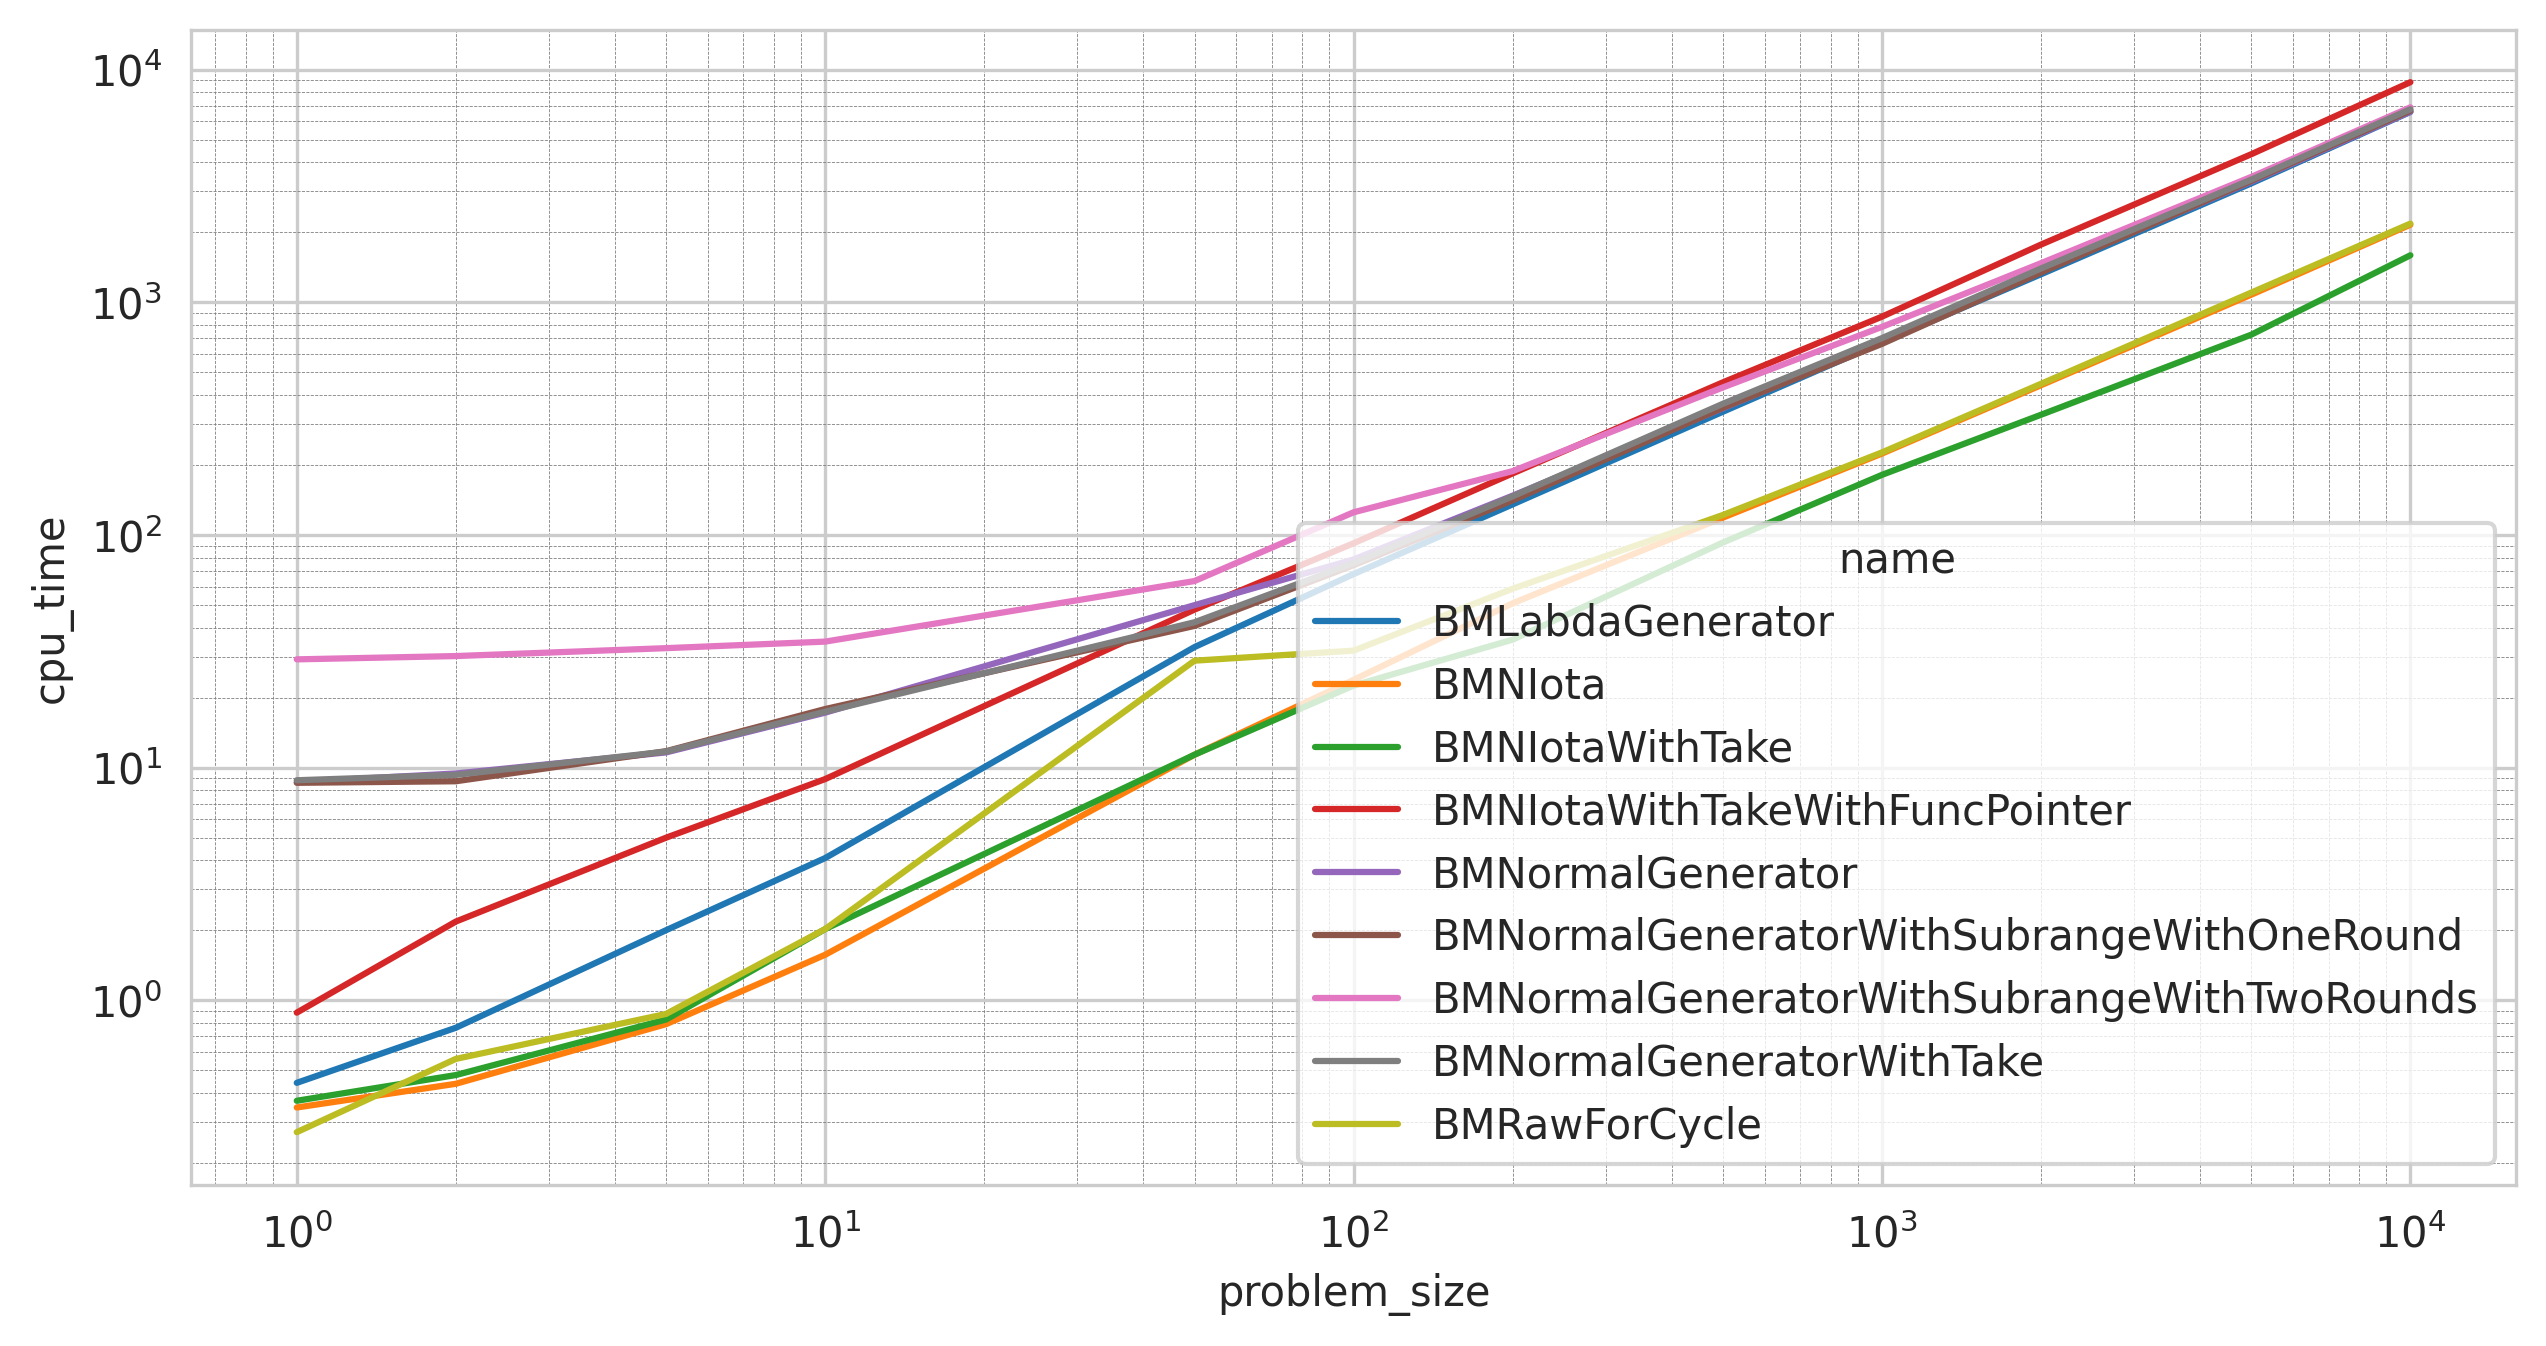

/home/bomkvilt/.local/lib/python3.11/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/home/bomkvilt/.local/lib/python3.11/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/home/bomkvilt/.local/lib/python3.11/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/home/bomkvilt/.local/lib/python3.11/site-package

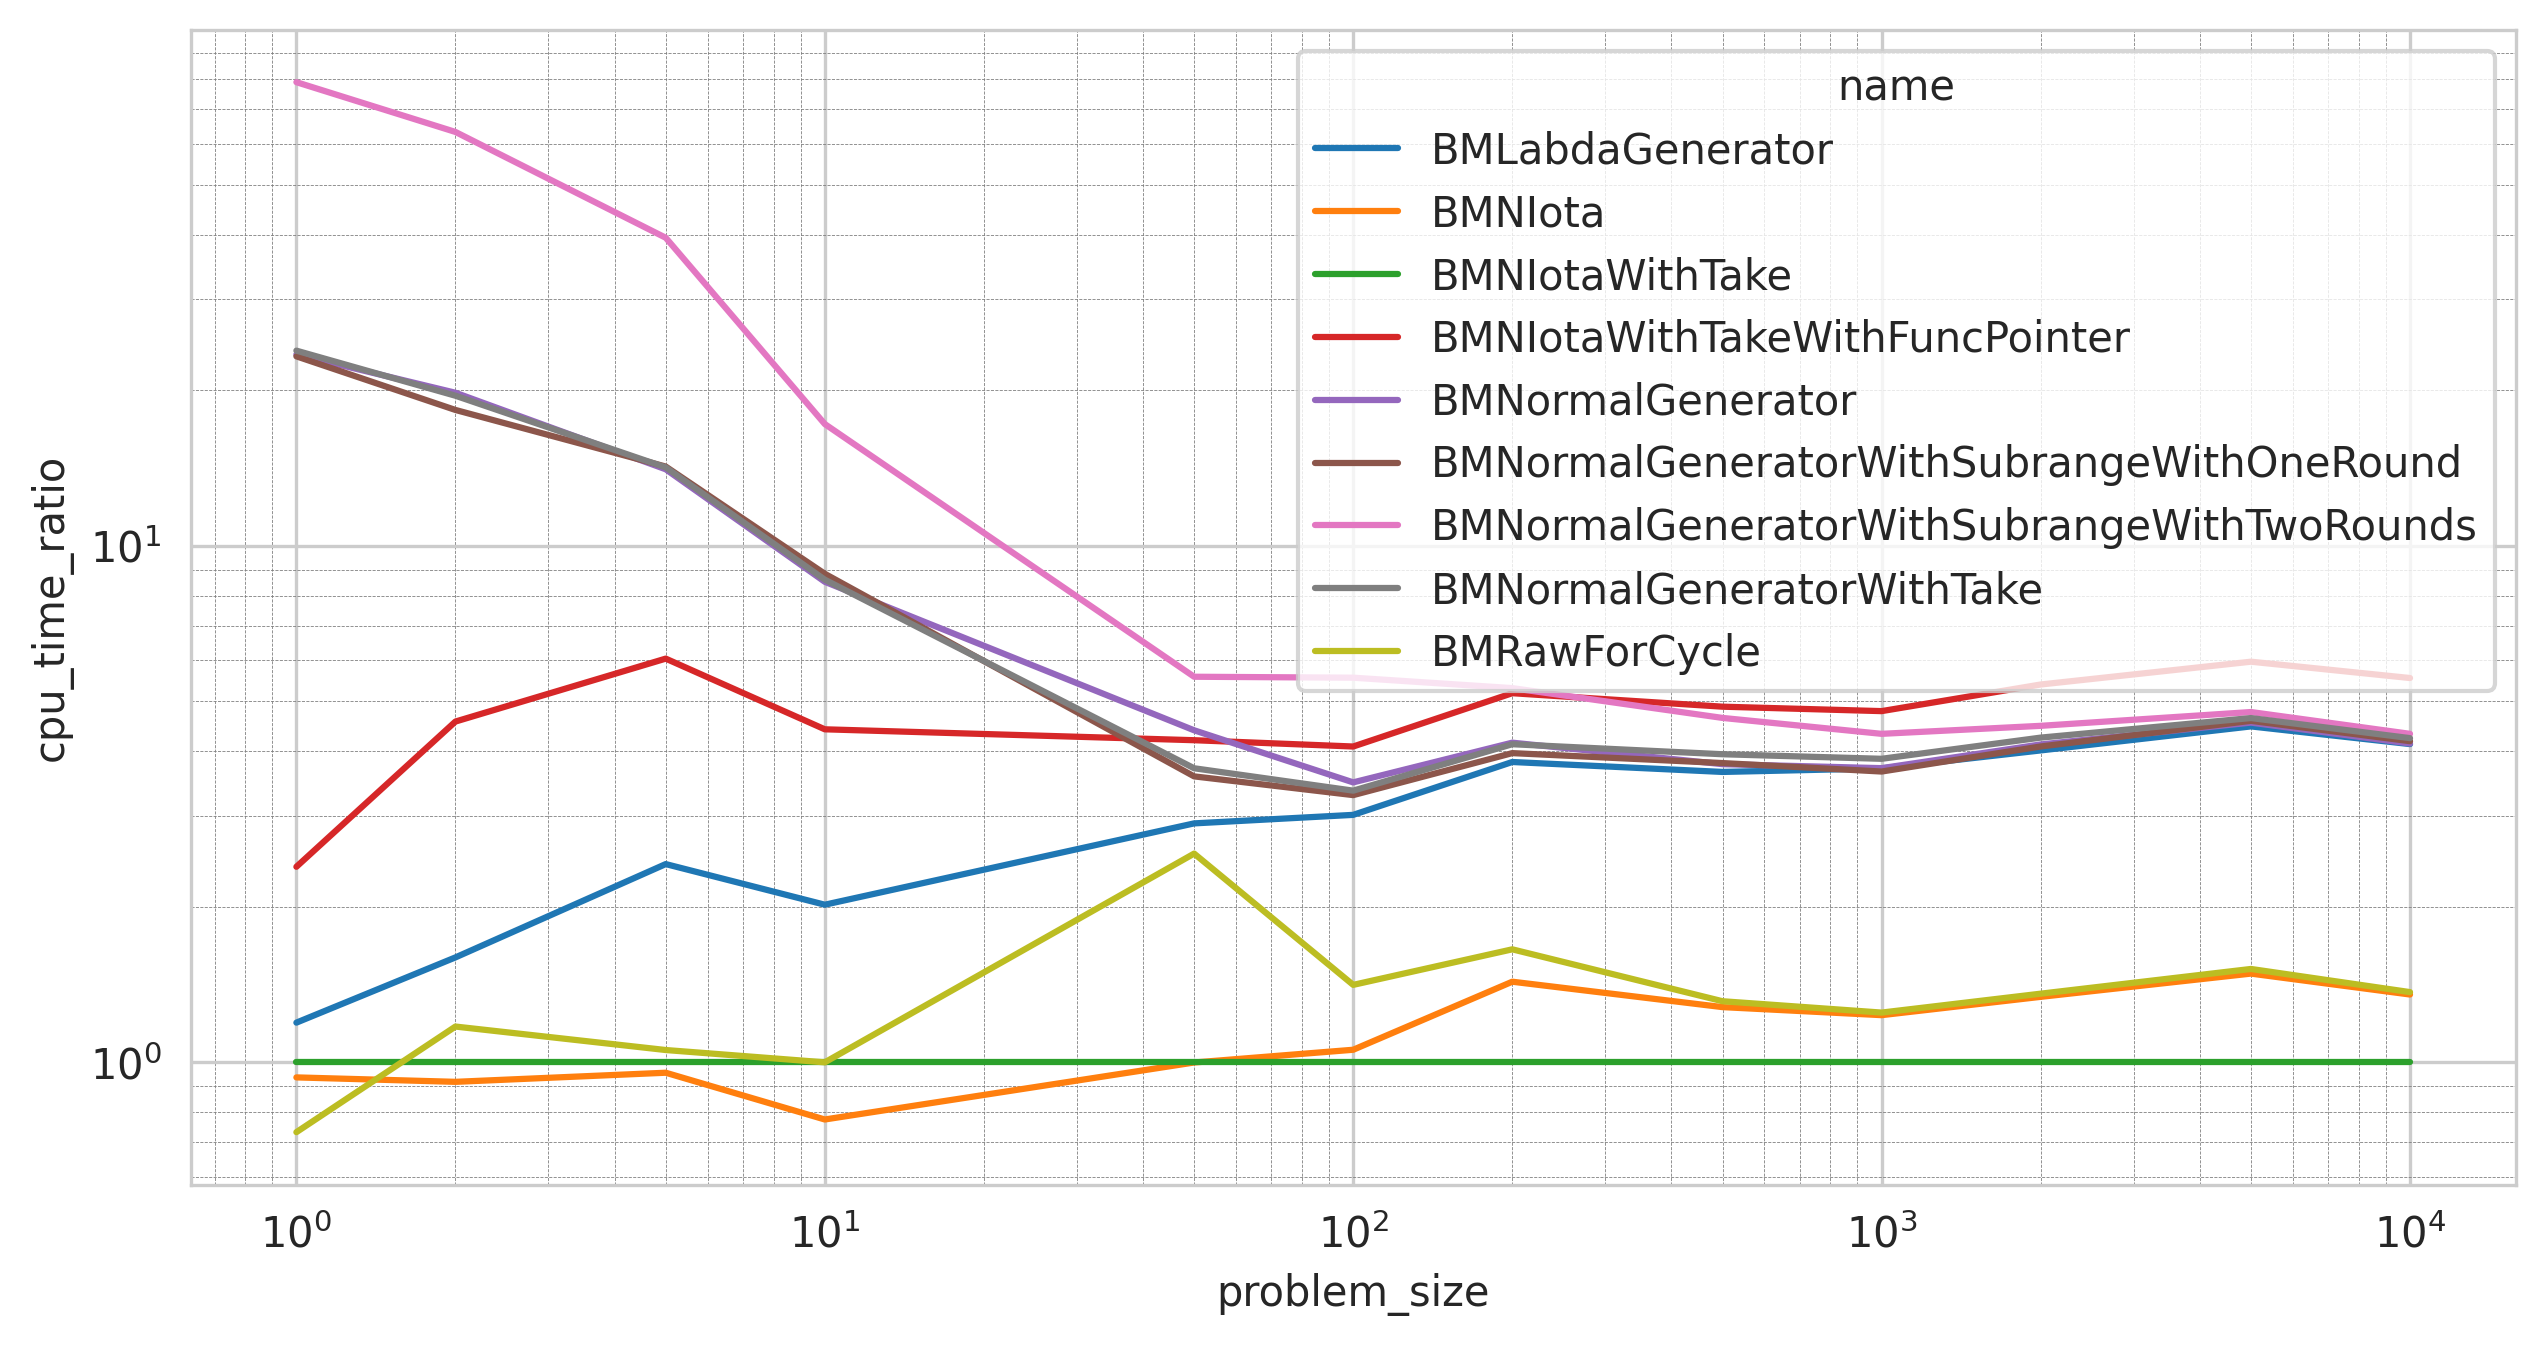

In [51]:
fig, ax = plt.subplots(figsize=(10, 5), dpi=300)
sns.set_style('whitegrid')
plot = sns.lineplot(benchmarks_df, x="problem_size", y="cpu_time", hue="name", ax=ax)
plot.set(xscale='log')
plot.set(yscale='log')
plt.grid(visible=True, which="minor", ls="--", color='gray', linewidth=0.2)
plt.show()
plt.close()


fig, ax = plt.subplots(figsize=(10, 5), dpi=300)
sns.set_style('whitegrid')
plot = sns.lineplot(benchmarks_df, x="problem_size", y="cpu_time_ratio", hue="name", ax=ax)
plot.set(xscale='log')
plot.set(yscale='log')
plt.grid(visible=True, which="minor", ls="--", color='gray', linewidth=0.2)
plt.show()
plt.close()
